In [1]:
from IPython.display import display, HTML
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
import torch
from PIL import Image
import torchvision.transforms as transforms

deviceID = 2
device = torch.device('cpu')

In [32]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [33]:
image = cv2.imread('images/lizard-boy.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (512, 512)) # for saving memory if use SD-pipeline

In [1]:
sys.path.append('face_parsing_PyTorch/')
from model import BiSeNet
n_classes = 19
net = BiSeNet(n_classes=n_classes)
net.to(device)
ckpt_path = 'face_parsing_PyTorch/res/cp/79999_iter.pth'
net.load_state_dict(
    torch.load(
        ckpt_path,
        map_location=torch.device('cpu')
    )
)
net.eval()

to_tensor = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])


NameError: name 'sys' is not defined

In [35]:
#plt.matshow(image)

with torch.no_grad():
    img = Image.fromarray(image)
    H, W = img.size[0], img.size[1]
    img = img.resize((512, 512), Image.BILINEAR)
    img = to_tensor(img)
    img = torch.unsqueeze(img, 0)
    img = img.to(device)
    out = net(img)[0]
    print("OUT SHAPE:  ", out.shape)
    print("OUT SHAPE SQUEEZED 0:   ", out.squeeze(0).shape)
    print("OUT SQUEEZED:     ", out.squeeze(0))
    parsing = out.squeeze(0).cpu().numpy().argmax(0)

num_of_class = np.max(parsing)

def pick_point(pi, label, parsing, W, H, w=512, h=512):
    print('shape of parsing', parsing.shape)
    print('PARSING:  ', parsing)
    print('PI   :   ', pi)
    index = np.where(parsing == pi)
    rand_idx = np.random.randint(0, len(index[0]))
    # WARNING: the order of x and y of the parsing is different from the cv2-image
    x, y = index[0][rand_idx] * W//w, index[1][rand_idx] * H//h
    point_coord = np.array([y, x]).reshape(1,2)
    point_label = np.array([label])
    return point_coord, point_label

hair_point, hair_label = pick_point(17, 1, parsing, W, H)
face_point, face_label = pick_point(1, 0, parsing, W, H)

OUT SHAPE:   torch.Size([1, 19, 512, 512])
OUT SHAPE SQUEEZED 0:    torch.Size([19, 512, 512])
OUT SQUEEZED:      tensor([[[ 5.2088,  5.1961,  5.1835,  ...,  5.6120,  5.5998,  5.5876],
         [ 5.2047,  5.1971,  5.1896,  ...,  5.6842,  5.6800,  5.6757],
         [ 5.2007,  5.1982,  5.1957,  ...,  5.7564,  5.7601,  5.7638],
         ...,
         [ 6.9605,  6.9557,  6.9509,  ...,  5.3320,  5.3614,  5.3908],
         [ 6.8669,  6.8560,  6.8450,  ...,  5.2655,  5.2903,  5.3152],
         [ 6.7734,  6.7562,  6.7390,  ...,  5.1989,  5.2193,  5.2397]],

        [[ 1.0222,  0.9378,  0.8535,  ...,  0.7465,  0.6926,  0.6386],
         [ 0.9296,  0.8449,  0.7602,  ...,  0.7823,  0.7235,  0.6648],
         [ 0.8370,  0.7520,  0.6670,  ...,  0.8180,  0.7545,  0.6909],
         ...,
         [-1.2000, -1.2246, -1.2493,  ..., -0.5083, -0.4209, -0.3336],
         [-1.1511, -1.1760, -1.2009,  ..., -0.5062, -0.4177, -0.3291],
         [-1.1021, -1.1273, -1.1526,  ..., -0.5041, -0.4144, -0.3246]],

  

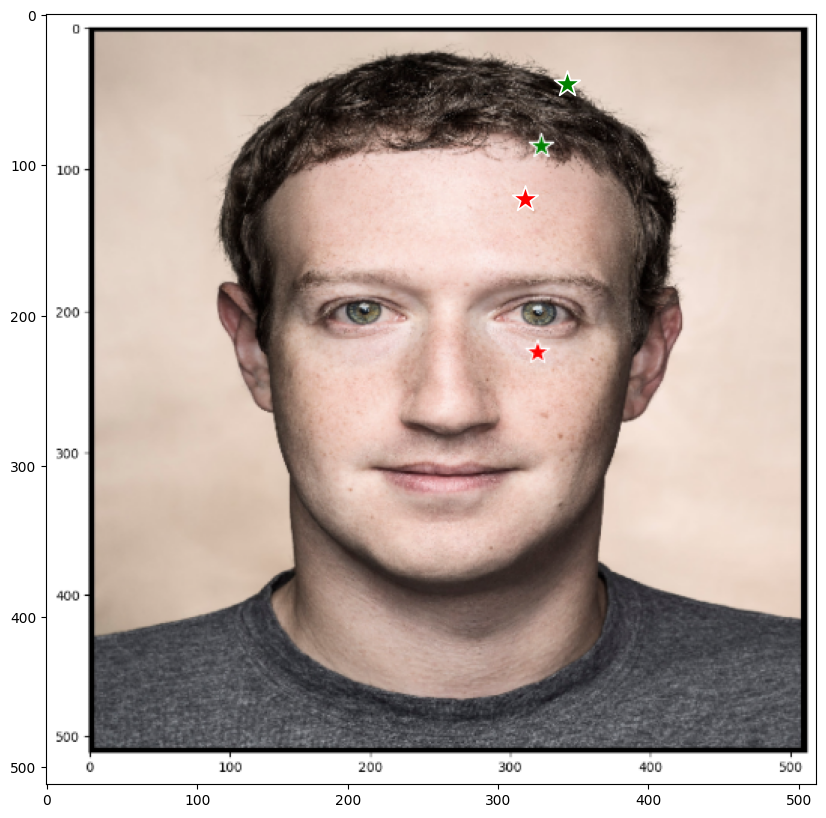

In [36]:
# check whether the points are in the right place
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(hair_point, hair_label, plt.gca())
show_points(face_point, face_label, plt.gca())
plt.axis('on')
plt.show() 

In [37]:
from segment_anything import build_sam, SamPredictor 
sam_checkpoint = './sam_vit_h_4b8939.pth'
predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint))
predictor.set_image(image)

In [38]:
masks, scores, logits = predictor.predict(
    point_coords=hair_point,
    point_labels=hair_label,
    multimask_output=True,
)

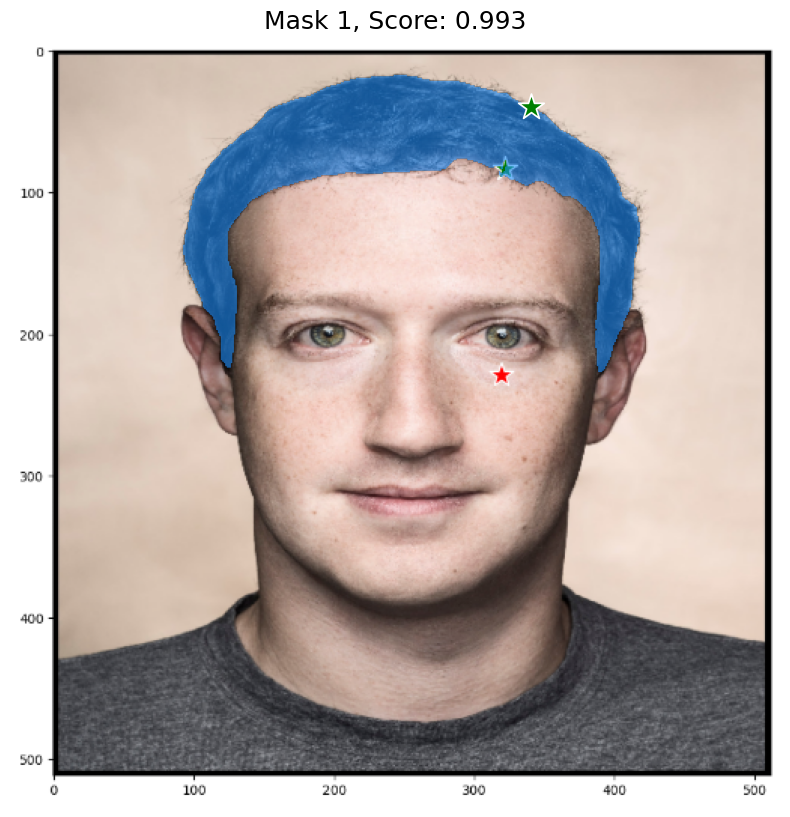

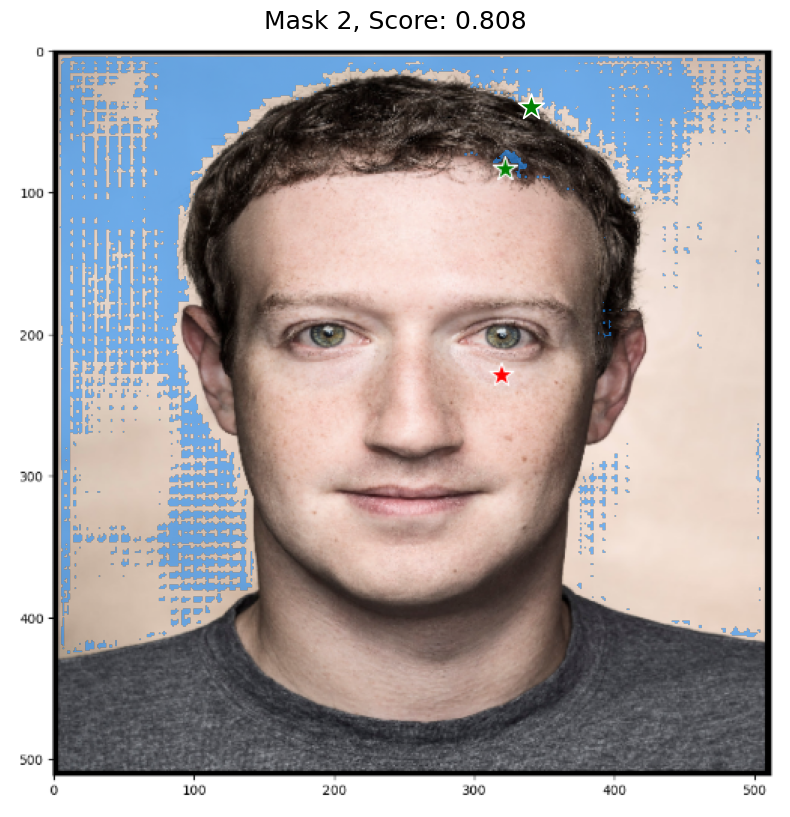

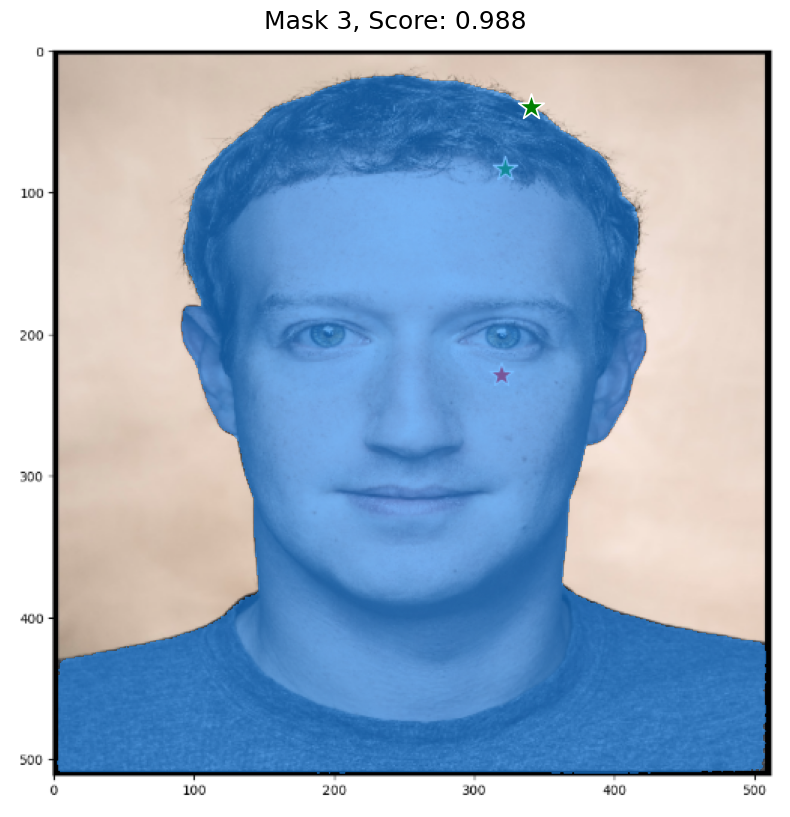

In [39]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(hair_point, hair_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

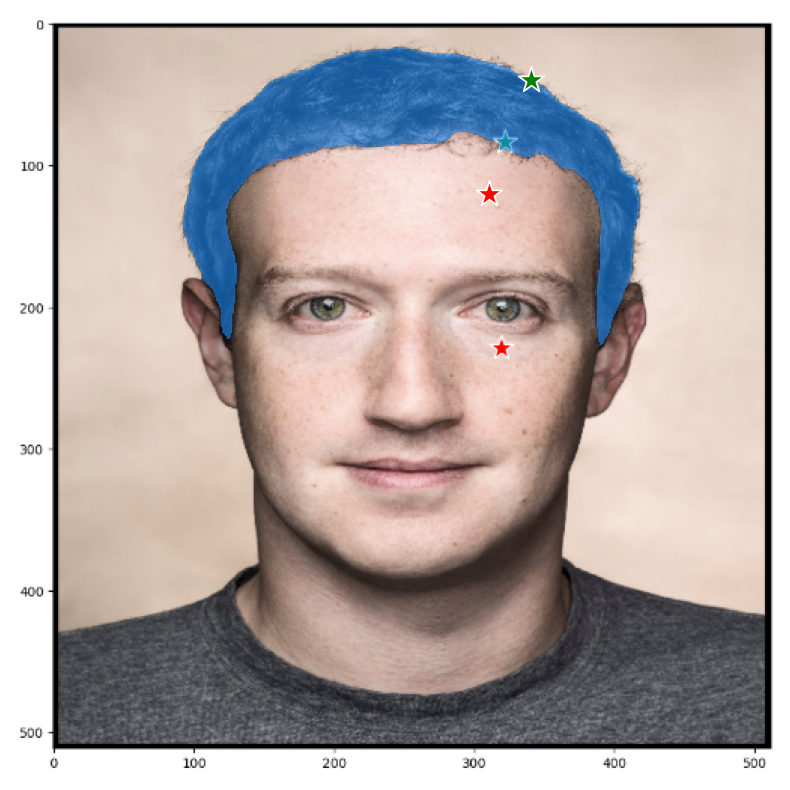

In [40]:
input_point = np.concatenate((hair_point, face_point), axis=0)
input_label = np.concatenate((hair_label, face_label), axis=0)
mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

In [41]:
mask_pil = Image.fromarray(masks[0])
image_pil = Image.fromarray(image)